# Sample Autoencoder

In this notebook a sample autoencoder model is presented, showcasing the functionalities from the source utility files, upon which all model implementations can be built.

## Add project root to path

In [ ]:
from pathlib import Path

src_root = Path.cwd().parent  # notebooks -> ml-sandbox

# Add source root to sys.path
import sys

if str(src_root) not in sys.path:
    sys.path.append(str(src_root))

## Import necessary modules

In [2]:
from src import (
    MnistDataset,
    Regressor,
    Autoencoder,
)

# Machine learning
import torch
from torch import nn as nn

## Define training hyperparameters

In [3]:
hparams = dict(
    # Training hyperparameters
    batch_size=64,
    num_epochs=10,
    # Model hyperparameters
    learning_rate=1e-3,
    regularization_weight=0.0,
)

## Define the model

In [ ]:
mnist = MnistDataset()
dataloaders = mnist.get_dataloaders(
    train_split=0.6, val_split=0.2, test_split=0.2, batch_size=hparams["batch_size"]
)

model = Autoencoder(dims=[28 * 28, 128, 64, 32], sigma=nn.LeakyReLU)

optimizer = torch.optim.Adam(model.parameters(), lr=hparams["learning_rate"])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=10,
)

trainer = Regressor(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    scheduler_metric=True,
    loss_function="MSE",
).initialize_regularization(method="L2", weight=hparams["regularization_weight"])

===== Dataset 'mnist' already exists and is valid. =====


2025-10-21 22:30:56,611 - ml-sandbox - INFO - Regularization initialized with the method L2 and weights beta1 = 0.0, beta2 = 0.1


## Train the model

In [ ]:
results = trainer.train(
    train_dataloader=dataloaders["train"],
    validation_dataloader=dataloaders["val"],
    epochs=hparams["num_epochs"],
)

2025-10-21 22:30:56,621 - ml-sandbox - INFO - ==================== Model training started ====================
2025-10-21 22:30:56,732 - ml-sandbox - INFO -  Training on device: cuda 
Training Progress:  10%|█         | 1/10 [00:07<01:05,  7.26s/epoch]

Epoch [1/10], Train Loss: 500.50, Val Loss: 1,505.48, Grad Norm: 4,540,580.67


Training Progress:  50%|█████     | 5/10 [00:24<00:22,  4.40s/epoch]

Epoch [5/10], Train Loss: 45.15, Val Loss: 516.21, Grad Norm: 798,714.26


Training Progress: 100%|██████████| 10/10 [00:42<00:00,  4.28s/epoch]
2025-10-21 22:31:39,506 - ml-sandbox - INFO - ==================== Training completed! TensorBoard logs saved to 'logs' ====================
2025-10-21 22:31:39,507 - ml-sandbox - INFO - To view logs, run from the console: tensorboard --logdir=logs


Epoch [10/10], Train Loss: 518.49, Val Loss: 886.18, Grad Norm: 1,955,152.74


## Print training results

In [ ]:
print("=" * 20 + " Training Results " + "=" * 20)

print(f"Final training loss: {results.train_loss:.4f}")
print(f"Final validation loss: {results.validation_loss:.4f}")

==================== Training Results ====================
Final training loss: 518.4939
Final validation loss: 886.1796


## Show sample reconstruction images

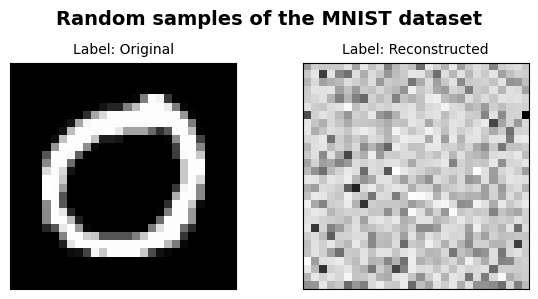

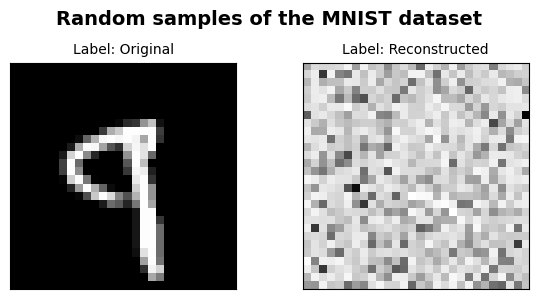

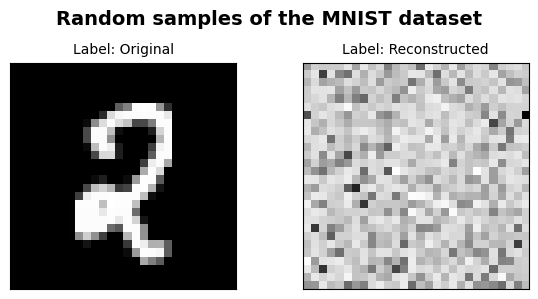

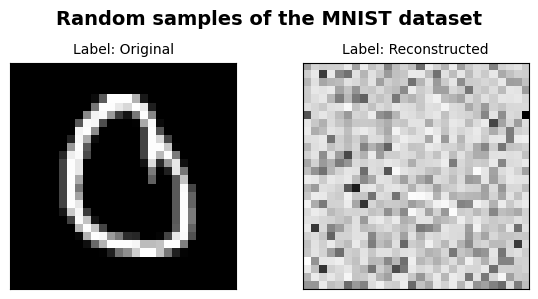

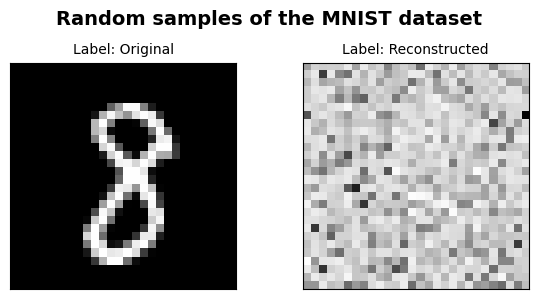

In [9]:
import random
from src.input_data.structure.base import ManagedDataset
from src.input_data.structure.plots import plot_samples


def show_random_samples(
    dataset: ManagedDataset, model: nn.Module, num_samples: int = 8, figsize=(12, 8)
) -> None:
    """Display random samples from the dataset."""
    if len(dataset) == 0:
        print("Dataset is empty!")
        return

    # Set model to evaluation mode and move to a proper device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Select random indices
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    with torch.no_grad():
        for idx in indices:
            image, target_idx = dataset[idx]

            image = image.to(device)

            image_reconstructed = model(image.unsqueeze(0)).squeeze(0)
            image_list = [image, image_reconstructed]
            label_list = ["Original", "Reconstructed"]

            plot_samples(
                image_list,
                labels=label_list,
                suptitle=f"Random samples of the {dataset.dataset_info.name} dataset",
            )


show_random_samples(mnist, model, num_samples=5)